In [28]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix

In [29]:
#torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")         # Use GPU if available
dataPath = '/content/drive/MyDrive/YuksekLisans/DLAPP/HW4/CaltechTinySplit/'    # Path of the data set

# Function to get the numbers of train, validation and test samples
def getDataSize(folderPath, format='.jpg'):
    fileCount = 0
    for root, dirs, files in os.walk(folderPath):
            for file in files:
                if file.endswith('.jpg'):
                    fileCount += 1
    return fileCount

trainSize = getDataSize(dataPath + 'train')
valSize = getDataSize(dataPath + 'val')
testSize = getDataSize(dataPath + 'test')

transform = transforms.Compose([
        #transforms.RandomRotation(20),
        #transforms.RandomResizedCrop(128),
        transforms.Resize((128,128)),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor()])

trainSet = datasets.ImageFolder(dataPath + 'train', transform=transform)
valSet = datasets.ImageFolder(dataPath + 'val', transform=transform)
testSet = datasets.ImageFolder(dataPath + 'test', transform=transform)

trainLoader = DataLoader(trainSet, batch_size=16, shuffle=True)
valLoader = DataLoader(valSet, batch_size=16, shuffle=False)
testLoader = DataLoader(testSet, batch_size=16, shuffle=False)

In [30]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, 1)
        self.conv2 = nn.Conv2d(8, 16, 3, 1)
        self.do1 = nn.Dropout(p=0.25)
        self.conv3 = nn.Conv2d(16, 32, 3, 1)
        self.conv4 = nn.Conv2d(32, 64, 3, 1)
        self.do2 = nn.Dropout(p=0.25)
        self.conv5 = nn.Conv2d(64, 128, 3, 1)
        self.conv6 = nn.Conv2d(128, 256, 3, 1)
        self.fc1 = nn.Linear(54*54*256, 256)
        self.do3 = nn.Dropout(p=0.25)
        self.fc2 = nn.Linear(256, 9)
        self.do4 = nn.Dropout(p=0.25)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.do1(x)
        x = F.silu(x)
        x = F.max_pool2d(x,2,2)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.do2(x)
        x = F.relu(x)
        x = torch.tanh(self.conv5(x))   # F.tanh() is depreciated
        x = F.silu(self.conv6(x))
        # To check the shape before fully connected layer
        #print(x.shape)
        x = x.view(-1,256*54*54)
        x = self.fc1(x)
        x = self.do3(x)
        x = self.fc2(x)     
        x = self.do4(x)
        """       
        F.softmax() should not be used with nn.CrossEntropyLoss()
        nn.CrossEntropyLoss() combines nn.LogSoftmax() and nn.NLLLoss()
        Either pass raw data to nn.CrossEntropyLoss()
        or use F.log_softmax() and pass it to nn.NLLLoss()
        """
        return F.log_softmax(x, dim=1)

In [31]:
#torch.manual_seed(42)
model = Net()
if torch.cuda.is_available():
    model.cuda()

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
epoch = 20

trainLossList = []      # List to store the average training loss of each epoch
trainCorrectList = []   # List to store the number of correctly predicted training samples per epoch
valLossList = []        # List to store the average validation loss of each epoch
valCorrectList = []     # List to store the number of correctly predicted validation samples per epoch
bestValLoss = np.inf    # To check if the validation loss is better than the one in previous epoch, if so then store the model state
modelState = None       # Variable to store the model state
modelPath = '/content/drive/MyDrive/YuksekLisans/DLAPP/HW4/model.pt'  # Path to save the model

In [32]:
for i in range(epoch):
    print(f'EPOCH: {i+1}')

    # Train
    trainCorrect = 0    # Set to 0 at the start of each epoch, will be increased for each batch
    trainLoss = 0       # Set to 0 at the start of each epoch, will be increased for each batch
    model.train()       # Train mode
    for b,(xTrain,yTrain) in enumerate(trainLoader):
        #b += 1
        xTrain, yTrain = xTrain.to(device), yTrain.to(device)
        yPred = model(xTrain)
        loss = criterion(yPred, yTrain)
        predicted = torch.max(yPred.data,1)[1]          # The index location of each maximum value found (argmax)
        trainCorrect += (predicted == yTrain).sum()     # Number of the correctly predicted training samples
        trainLoss += loss * yTrain.size(0)              # Total training loss, will be divided by sample size to get the average loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    trainCorrectList.append(trainCorrect)
    avgTrainLoss = trainLoss / trainSize
    trainLossList.append(avgTrainLoss)
    print(f'[Train     ] Loss: {trainLossList[i]}\tAccuracy: {trainCorrectList[i]/trainSize}')           

    # Validation
    valCorrect = 0  # Set to 0 at the start of each epoch, will be increased for each batch
    valLoss = 0     # Set to 0 at the start of each epoch, will be increased for each batch
    model.eval()    # Validation/Test mode
    with torch.no_grad():  
        for b,(xVal,yVal) in enumerate(valLoader):
            #b += 1
            xVal, yVal = xVal.to(device), yVal.to(device)
            yPred = model(xVal)
            loss = criterion(yPred, yVal)
            predicted = torch.max(yPred.data,1)[1]      # The index location of each maximum value found (argmax)
            valCorrect += (predicted == yVal).sum()     # Number of the correctly predicted validation samples
            valLoss += loss * yVal.size(0)              # Total validation loss, will be divided by sample size to get the average loss
            
    valCorrectList.append(valCorrect)
    avgValLoss = valLoss / valSize
    valLossList.append(avgValLoss)
    print(f'[Validation] Loss: {valLossList[i]}\tAccuracy: {valCorrectList[i]/valSize}')

    # If the validation loss is better than the one in previous epoch, store the model state
    if valLossList[i] < bestValLoss:
        bestValLoss = valLossList[i]
        modelState = {
            'epoch': (i+1),
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': valLossList[i],
            }
        print('The validation loss is better, model state is stored.')

    else:
        print('The validation loss is not better!')
    
    print('Learning rate:', optimizer.param_groups[0]['lr'])
    scheduler.step()    # Decay the learning rate
    print('-' * 75)     # End of the epoch

# After the training, save the model with best validation loss
print('Saving the model with best validation loss...')
torch.save(modelState, modelPath)

EPOCH: 1
[Train     ] Loss: 1.2359548807144165	Accuracy: 0.6307578086853027
[Validation] Loss: 0.7475685477256775	Accuracy: 0.7878787517547607
The validation loss is better, model state is stored.
Learning rate: 0.0001
---------------------------------------------------------------------------
EPOCH: 2
[Train     ] Loss: 0.8432537913322449	Accuracy: 0.748142659664154
[Validation] Loss: 0.6814295649528503	Accuracy: 0.781818151473999
The validation loss is better, model state is stored.
Learning rate: 0.0001
---------------------------------------------------------------------------
EPOCH: 3
[Train     ] Loss: 0.7790939211845398	Accuracy: 0.7786032557487488
[Validation] Loss: 0.571520209312439	Accuracy: 0.8242424130439758
The validation loss is better, model state is stored.
Learning rate: 0.0001
---------------------------------------------------------------------------
EPOCH: 4
[Train     ] Loss: 0.6426935791969299	Accuracy: 0.8001485466957092
[Validation] Loss: 0.49104049801826477	Acc

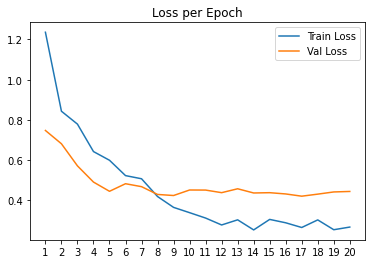

In [33]:
# Plot train and validation loss
labelEpochNo = [str(i) for i in range(1,epoch+1)]
plt.plot(labelEpochNo, trainLossList, label='Train Loss')
plt.plot(labelEpochNo, valLossList, label='Val Loss')
plt.title('Loss per Epoch')
plt.legend()

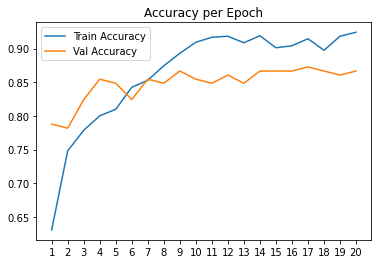

In [34]:
# Plot train and validation accuracy
plt.plot(labelEpochNo, np.divide(trainCorrectList,trainSize), label='Train Accuracy')
plt.plot(labelEpochNo, np.divide(valCorrectList,valSize), label='Val Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

In [35]:
# Load the trained model with best validation loss
print('Loading the model...')
checkpoint = torch.load(modelPath)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

Loading the model...


In [36]:
# Test
testCorrect = 0     # Set to 0 at the start of each epoch, will be increased for each batch
testLoss = 0        # Set to 0 at the start of each epoch, will be increased for each batch

testPredictions = []    # List to store the test predictions
testLabels = []         # List to store the corresponding test labels

model.eval()        # Validation/Test mode
with torch.no_grad():  
    for b,(xTest,yTest) in enumerate(testLoader):
        #b += 1
        xTest, yTest = xTest.to(device), yTest.to(device)
        yPred = model(xTest)
        loss = criterion(yPred, yTest)
        predicted = torch.max(yPred.data,1)[1]      # The index location of each maximum value found (argmax)
        testCorrect += (predicted == yTest).sum()   # Number of the correctly predicted test samples
        testLoss += loss * yTest.size(0)            # Total test loss, will be divided by sample size to get the average loss
        testPredictions.extend(predicted.cpu().view(-1))
        testLabels.extend(yTest.cpu().view(-1))

avgTestLoss = testLoss / testSize

print(f'[Test      ] Loss: {avgTestLoss}\tAccuracy: {testCorrect/testSize}')

[Test      ] Loss: 0.3257734179496765	Accuracy: 0.9022988677024841


In [37]:
# Print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(9).reshape(1,9))
# Print class names
print(testSet.class_to_idx)
# Print the confusion matrix
print(confusion_matrix(testPredictions, testLabels))

[[   0    1    2    3    4    5    6    7    8]]
{'Faces': 0, 'Motorbikes': 1, 'camera': 2, 'cannon': 3, 'cellphone': 4, 'flamingo': 5, 'hawksbill': 6, 'ibis': 7, 'pizza': 8}
[[  44    1    0    0    0    2    0    2    3]
 [   0   80    1    1    0    0    0    0    0]
 [   0    0    3    0    0    1    0    0    0]
 [   0    0    0    3    0    0    0    0    0]
 [   0    0    0    0    6    0    0    0    0]
 [   0    0    0    0    0    4    0    2    0]
 [   0    0    0    0    0    0   10    0    0]
 [   0    0    1    1    1    1    0    4    0]
 [   0    0    0    0    0    0    0    0    3]]
